#**Undestanding Machine Learning Models**

In [147]:
%%capture
!pip install lime
!pip install shap

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

import shap

# Begginning

In [149]:
path = '/content/drive/MyDrive/Data/cancer_data.csv'

whole_data = pd.read_csv(path)
y = whole_data.diagnosis

features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'] # or list(set(data.columns))

whole_data = whole_data[features + ['diagnosis']]
data = whole_data[features]
y = y.map(lambda p: 1 if p == 'M' else 0)



'Diagnosis' is the column which we are going to predict , which says if the cancer is M = malignant or B = benign. 1 means the cancer is malignant and 0 means benign. 

In [150]:
# data a liitle unbalanced but it's OK
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [151]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.15, shuffle=True, random_state=2)

In [152]:
data.head()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0                 0.07871  ...         25.38          17.33           184.60   
1                 0.05667  ...         24.99          23.41           158.80   
2                 0.05999  ...         23.57          25.53           152.50   
3                 0.09744  ...         14.91          26.50            98.87   
4                 0.05883  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 30 columns]

# Scale Data

In [153]:
scaler = StandardScaler()
scaler.fit(data_train)
data_train_scale = scaler.transform(data_train)
data_test_scale = scaler.transform(data_test)
data_scale = scaler.transform(data)

#  Logistic Regression

In [154]:
reg = LogisticRegression()
reg.fit(data_train_scale, y_train)

LogisticRegression()

In [155]:
print(classification_report(y_train, reg.predict(data_train_scale)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       304
           1       0.99      0.98      0.99       179

    accuracy                           0.99       483
   macro avg       0.99      0.99      0.99       483
weighted avg       0.99      0.99      0.99       483



In [156]:
print(classification_report(y_test, reg.predict(data_test_scale)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.94      0.97      0.96        33

    accuracy                           0.97        86
   macro avg       0.96      0.97      0.96        86
weighted avg       0.97      0.97      0.97        86



Recall on train: 0.98  \
Recall on test: 0.97. \
Not bad:)

### Lime

In [336]:
import lime
from lime import lime_tabular

In [337]:
reg.predict_proba(data_test_scale[(72, ),:])

array([[0.99695124, 0.00304876]])

In [338]:
y_reg_pred = reg.predict(data_test_scale)
sum(y_test == y_reg_pred)

83

So it's 3 cases which give wrong prediction.

In [340]:
print(f'The first index of incorrect prediction is {np.array((y_test == y_reg_pred)).argmin()}')
print(f'Correct value is {y_test.iloc[37]}')
print(f'Predicted value is {y_reg_pred[37]}')

The first index of incorrect prediction is 37
Correct value is 1
Predicted value is 0


In [343]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(data_train_scale),
    feature_names=features,
    class_names=[0, 1],
    mode='classification')

exp = explainer.explain_instance(
    data_row=pd.DataFrame(data_test_scale, columns=features).iloc[37], 
    predict_fn=reg.predict_proba
)

exp.show_in_notebook(show_table=True)

So LIME sees 4 features which resposible for cancer and they level out by many other weak features

### Feature Importance

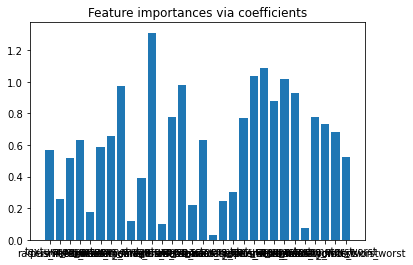

In [129]:
importance = np.abs(reg.coef_)
plt.bar(height=importance.squeeze(), x=features, width=0.8)
plt.title("Feature importances via coefficients")
plt.show()

<BarContainer object of 30 artists>

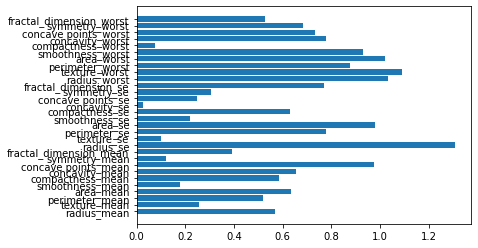

In [345]:
plt.barh(features, importance.squeeze(), align='center')

In [349]:
importance_dict = dict(zip(features, importance.squeeze()))
sorted(importance_dict.items(), key=lambda x: x[1])[:-18:-1]

[('radius_se', 1.310517354475651),
 ('texture_worst', 1.0899984399242568),
 ('radius_worst', 1.0348960759909014),
 ('area_worst', 1.0204962095673213),
 ('area_se', 0.9814063958284392),
 ('concave points_mean', 0.9744133298062302),
 ('smoothness_worst', 0.9321197804325472),
 ('perimeter_worst', 0.8779552948851438),
 ('perimeter_se', 0.780433580800312),
 ('concavity_worst', 0.7789226558246478),
 ('fractal_dimension_se', 0.7690941187207785),
 ('concave points_worst', 0.732051774402242),
 ('symmetry_worst', 0.682900983233757),
 ('concavity_mean', 0.6557005095578803),
 ('area_mean', 0.6350730408141219),
 ('compactness_se', 0.6317467228722382),
 ('compactness_mean', 0.5858954115133275)]

There are so many important features, seems model uses almost all features

# Overfitted Model: Random Forest



In [21]:
rf_model = RandomForestClassifier(random_state=21, n_jobs=-1, n_estimators=200) 
rf_model.fit(data_train, y_train)

rf_predictions = rf_model.predict(data_test)
train_predictions = rf_model.predict(data_train)

rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_train_accuracy = accuracy_score(y_train, train_predictions)

print("Basic Model Train Accuracy is {}".format(rf_train_accuracy))
print("Basic Model Test Accuracy is {}".format(rf_accuracy))


Basic Model Train Accuracy is 1.0
Basic Model Test Accuracy is 0.9302325581395349


In [22]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        52
           1       0.97      0.85      0.91        34

    accuracy                           0.93        86
   macro avg       0.94      0.92      0.93        86
weighted avg       0.93      0.93      0.93        86



In [23]:
print(classification_report(y_train, train_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       305
           1       1.00      1.00      1.00       178

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483



### Analize feature importance using built-in Scikit-Learn Methods
>> Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. [Source](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [309]:
importances = np.around((rf_model.feature_importances_)*100, decimals=1)
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances_model = pd.Series(importances, index=features)
print(f'Importances already normalized {importances.sum()}')

Importances already normalized 100.0


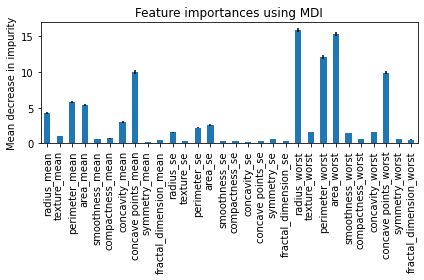

In [301]:
fig, ax = plt.subplots()
forest_importances_model.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<BarContainer object of 30 artists>

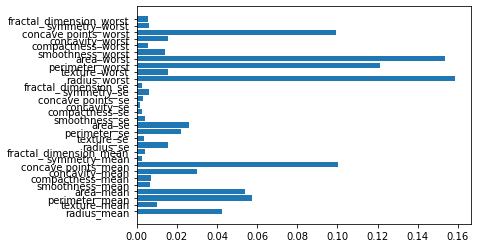

In [302]:
plt.barh(features, rf_model.feature_importances_, align='center')

The first 13 features which give the biggest inpact

In [310]:
forest_importances_model.sort_values(ascending=False).head(13)

radius_worst            15.9
area_worst              15.4
perimeter_worst         12.1
concave points_mean     10.0
concave points_worst     9.9
perimeter_mean           5.8
area_mean                5.4
radius_mean              4.3
concavity_mean           3.0
area_se                  2.6
perimeter_se             2.2
texture_worst            1.6
concavity_worst          1.6
dtype: float64

###Feature importance based on feature permutation
>> Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [311]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, data_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
norm_result = np.around((result.importances_mean / result.importances_mean.sum()) * 100, decimals=1)

forest_importances_permutation = pd.Series(norm_result, index=features)

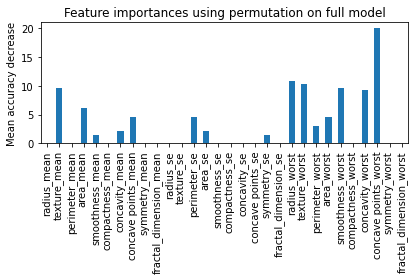

In [312]:
fig, ax = plt.subplots()
forest_importances_permutation.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Choose Best Features


In [319]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest()
selector.fit(data_train, y_train)
params_best = selector.feature_names_in_
sk_scores = np.around(selector.scores_ / selector.scores_.sum() * 100, decimals=1)
forest_importances_kb = pd.Series(sk_scores, index=features)

Chech how new features work with the same Random Forest model

In [280]:
X_sk = data_train[params_best]
X_sk_train, X_sk_test, y_sk_train, y_sk_test = train_test_split(data_train, y_train, random_state=1, test_size=0.2)
rf_model.fit(X_sk_train, y_sk_train)

rf_sk_predictions = rf_model.predict(X_sk_test)
train_sk_predictions = rf_model.predict(X_sk_train)

rf_imp_accuracy = accuracy_score(y_sk_test, rf_sk_predictions)
rf_imp_train_accuracy = accuracy_score(y_sk_train, train_sk_predictions)

print("Basic Model Train Accuracy is {}".format(rf_imp_train_accuracy))
print("Basic Model Test Accuracy is {}".format(rf_imp_accuracy))

Basic Model Train Accuracy is 1.0
Basic Model Test Accuracy is 0.9896907216494846


In [281]:
print(classification_report(y_sk_test, rf_sk_predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        59
           1       0.97      1.00      0.99        38

    accuracy                           0.99        97
   macro avg       0.99      0.99      0.99        97
weighted avg       0.99      0.99      0.99        97



#### Create DataFrame if Important Features

In [330]:
if_dict = {
    'from_model': forest_importances_model,
    'permuntations': forest_importances_permutation,
    'select_k_best': forest_importances_kb
}
importante_features_df = pd.DataFrame(if_dict)
importante_features_df['sum_of_all'] = importante_features_df.sum(axis=1)

In [331]:
importante_features_df

from_model  permuntations  select_k_best  sum_of_all
radius_mean                     4.3            0.0            6.8        11.1
texture_mean                    1.0            9.7            1.1        11.8
perimeter_mean                  5.8            0.0            7.3        13.1
area_mean                       5.4            6.2            5.9        17.5
smoothness_mean                 0.7            1.5            0.9         3.1
compactness_mean                0.7            0.0            3.3         4.0
concavity_mean                  3.0            2.1            6.2        11.3
concave points_mean            10.0            4.6            9.0        23.6
symmetry_mean                   0.3            0.0            0.8         1.1
fractal_dimension_mean          0.4            0.0            0.0         0.4
radius_se                       1.5            0.0            2.8         4.3
texture_se                      0.4            0.0            0.0         0.4
perimeter_se                    2.2            4.6            2.6         9.4
area_se                         2.6            2.1            2.4         7.1
smoothness_se                   0.4            0.0            0.0         0.4
compactness_se                  0.3            0.0            0.6         0.9
concavity_se                    0.2            0.0            0.6         0.8
concave points_se               0.3            0.0            1.5         1.8
symmetry_se                     0.6            1.5            0.0         2.1
fractal_dimension_se            0.3            0.0            0.1         0.4
radius_worst                   15.9           10.8            9.1        35.8
texture_worst                   1.6           10.3            1.5        13.4
perimeter_worst                12.1            3.1            9.4        24.6
area_worst                     15.4            4.6            7.1        27.1
smoothness_worst                1.4            9.7            1.3        12.4
compactness_worst               0.6            0.0            3.2         3.8
concavity_worst                 1.6            9.2            4.6        15.4
concave points_worst            9.9           20.0            9.9        39.8
symmetry_worst                  0.6            0.0            1.2         1.8
fractal_dimension_worst         0.5            0.0            0.7         1.2

It's cleary seen that all methods consider 'radius_worst', 'area_worst', 'concave points_worst' as a very important features

### Use SHAP

Find incorrect prediction

In [29]:
print(f'The first index of incorrect prediction is {np.array((y_test == rf_predictions)).argmin()}')
print(f'Correct value is {y_test.iloc[0]}')
print(f'Predicted value is {rf_predictions[0]}')

The first index of incorrect prediction is 0
Correct value is 0
Predicted value is 1


In [96]:
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(data_train)

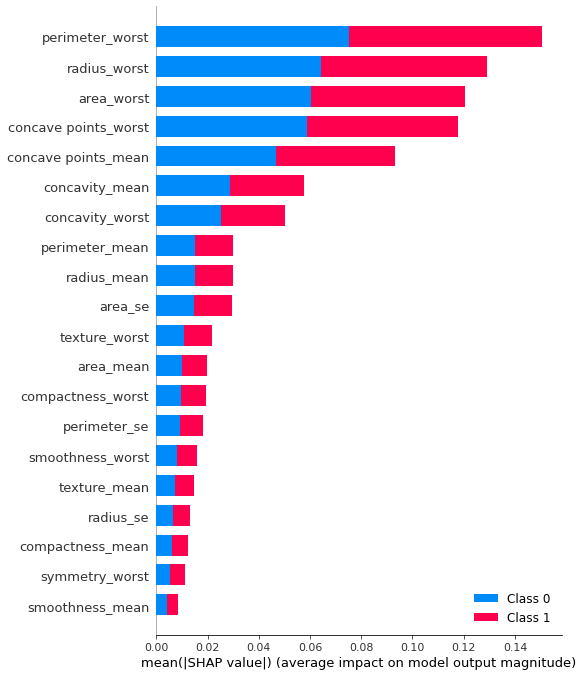

In [97]:
shap.summary_plot(shap_values_rf, data_train)

Let's compare this result to previous results took from sk-learn

In [334]:
importante_features_df.sum_of_all.sort_values(ascending=False)[:7]

concave points_worst    39.8
radius_worst            35.8
area_worst              27.1
perimeter_worst         24.6
concave points_mean     23.6
area_mean               17.5
concavity_worst         15.4
Name: sum_of_all, dtype: float64

They are pretty much same, no surprise

In [136]:
# let's explain incorrect prediction 
# visualize the first prediction's explanation
shap.initjs()
shap_values_0 = explainer_rf.shap_values(data_test[0:1])
print(f'Predicted value is {rf_predictions[0]}')
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0][0, :], feature_names=features)

Predicted value is 1


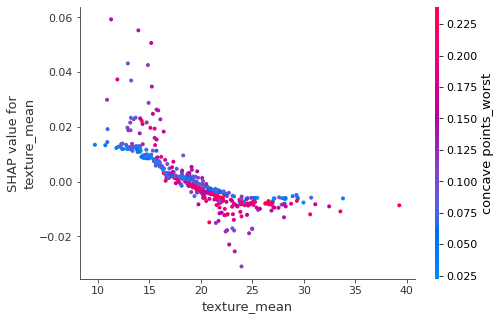

In [99]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
# better to itterate for most contribiution features
shap.initjs()
shap.dependence_plot(1, shap_values_rf[0], features=data_train, feature_names=features)

In [106]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0], feature_names=features)